# Dataless Neural Network for MIS finding in Graphs

## 1. Generate a random dense graph using NetworkX
This will be the graph that we find the MIS of

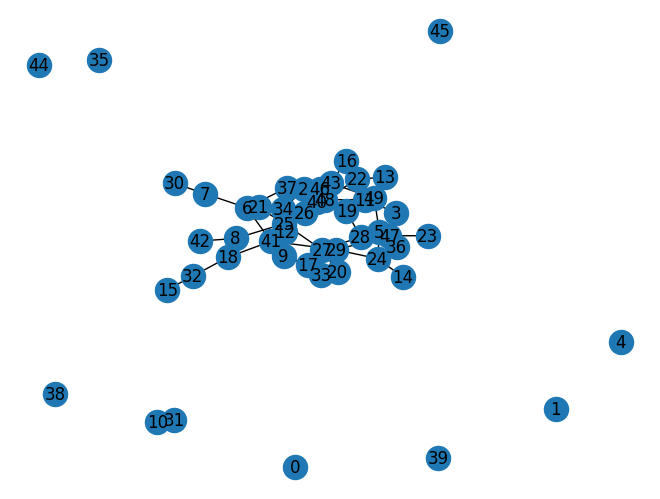

In [49]:
import networkx as nx

NUMBER_OF_NODES = 50
NUMBER_OF_EDGES = 50
SEED = 69

G = nx.generators.dense_gnm_random_graph(NUMBER_OF_NODES, NUMBER_OF_EDGES, seed=SEED)

nx.draw(G,with_labels=True)

## 2. Generate a neural network to solve your graph's MIS

### Initilize neural network weights based on the nodes, edges, and complement edges of your graph

In [50]:
import time
import networkx as nx
import torch
import numpy as np

def datalessNN_graph_params(graph, seed=10, numpy_dtype=np.float32, torch_dtype=torch.float32):

    ## Normalize graph labels to 0 - {Number of nodes} (this will help with indexing our graph-related weights)
    G = nx.relabel.convert_node_labels_to_integers(graph)

    

    ## Set numpy seed. This is used for theta initialization
    np.random.seed(seed=seed)

    ## Graph order: number of nodes. Graph size: number of edges.
    graph_order = len((G.nodes))
    graph_size = len((G.edges))
    graph_complement_size = (graph_order*(graph_order-1))//2 - graph_size

    ##################################################################################################
    ##################################################################################################
    ################### MODIFY WEIGHTS of NN_p BASED ON GRAPH
    ##################################################################################################
    ##################################################################################################

    ##############################
    ## Theta value initilization
    ##############################
    list_of_node_degrees = [None]*graph_order
    for i in range(0, graph_order):
        list_of_node_degrees[i] = G.degree[i]
    
    max_node_degree_in_graph = np.max(list_of_node_degrees)

    theta_vector = np.zeros(graph_order, dtype=numpy_dtype)

    for i in range(0, graph_order):
        ## To prevent exact repititive probability: add some very small epsilon
        theta_vector[i] = (
            1 - (list_of_node_degrees[i] / max_node_degree_in_graph) + np.random.uniform(low=0.0, high=0.1)
        )

    ###############################################
    ## Second layer weight and bias initilization
    ###############################################

    #### This is the numpy array we need to update the weights of the second layer (N x (N+M+Mc))
    second_layer_weights = np.zeros(shape=(graph_order, graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)

    #### Initilize the portion of the weight matrix reserved for the nodes of G
    for i in range(graph_order):
        second_layer_weights[i, i] = 1.0  # this stays the same


    #### Initilize the portion of the weight matrix reserved for the edges of G
    for idx, pair in enumerate(G.edges):
        second_layer_weights[pair[0], graph_order + idx] = 1.0
        second_layer_weights[pair[1], graph_order + idx] = 1.0

    #### Initilize the portion of the weight matrix reserved for the edges of G'
    G_complement = nx.complement(G)
    for idx, pair in enumerate(G_complement.edges):
        second_layer_weights[pair[0], graph_order + graph_size + idx] = 1.0
        second_layer_weights[pair[1], graph_order + graph_size + idx] = 1.0
    del G_complement


    #### This is the numpy array we need to update the biases of the second layer (N+M+Mc)
    second_layer_biases = np.zeros(shape=(graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)

    ## Initilize the portion of the bias vector reserved for the nodes of G
    second_layer_biases[0:graph_order] = -0.5

    ## Initilize the portion of the bias vector reserved for the edges of G and G'
    second_layer_biases[
        graph_order : graph_order + graph_size + graph_complement_size
    ] = -1.0

    ##############################################
    ## Third layer weight initilization
    ##############################################

    #### This is the numpy array we need to update the weights of the third layer (N+M+Mc)
    third_layer_weights = np.zeros(shape=(graph_order + graph_size + graph_complement_size), dtype=numpy_dtype)


    #### add here from graph:
    third_layer_weights[0:graph_order] = -1.0
    third_layer_weights[graph_order : graph_order + graph_size] = graph_order
    third_layer_weights[graph_order + graph_size :] = -1.0

    T_1 = torch.clamp(torch.tensor(theta_vector, dtype=torch_dtype), 0.1, 0.9)
    W_2 = torch.tensor(second_layer_weights, dtype=torch_dtype)
    B_2 = torch.tensor(second_layer_biases, dtype=torch_dtype)
    W_3 = torch.tensor(third_layer_weights, dtype=torch_dtype)

    return {"theta_tensor": T_1, "layer_2_weights": W_2, "layer_2_biases": B_2, "layer_3_weights": W_3}

### Initialize neural network structure using the weights we found earlier

In [51]:
import torch
import numpy as np

class ElementwiseMultiply(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features, out_features, lower_bound=0, upper_bound=1):
        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        weights = torch.Tensor(in_features, out_features)
        self.weight = torch.nn.Parameter(weights)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def forward(self, x):        
        # Perform element-wise multiplication
        result = torch.mul(torch.Tensor(x), self.weight.t())
        
        # Bound the output between the specified lower and upper bounds
        result = torch.clamp(result, self.lower_bound, self.upper_bound)
        return result
    
class ZeroOneClamp(object):
    def __init__(self):
        pass

    def __call__(self, module):
        w = module.weight.data
        module.weight.data = torch.clamp(w, 0, 1)


def datalessNN(theta_tensor, layer2_weights, layer2_biases, layer3_weights, numpy_dype=np.float32, torch_dtype=torch.float32):

    graph_order = len(theta_tensor)
    graph_nodes_and_all_possible_edges = len(layer2_biases)

    ##################################################################3################################################
    ################################3 initialize NN ##################################################################3
    ##################################################################3################################################

    NN = torch.nn.Sequential()

    ###############################
    ## Theta Layer initialization
    ###############################
    theta_layer = ElementwiseMultiply(in_features=graph_order, out_features=graph_order)

    # Temporarily disable gradient calc to set initial weights
    with torch.no_grad():
        theta_layer.weight.data = theta_tensor

    NN.append(theta_layer)

    ################################
    ## Second Layer initialization
    ################################
    layer2 = torch.nn.Linear(
        in_features=graph_order,
        out_features=graph_nodes_and_all_possible_edges,
        bias=True,
        dtype=torch_dtype
    )
    # add ReLu activation layer to layer 2
    layer2_activation = torch.nn.ReLU()

    # make layer non-trainable
    layer2.requires_grad_(False)

    # Initialize weights and biases
    layer2.weight.data = np.transpose(layer2_weights)
    layer2.bias.data = layer2_biases

    NN.append(layer2)
    NN.append(layer2_activation)

    ###############################
    ## Third Layer initialization
    ###############################
    layer3 = torch.nn.Linear(
        in_features=graph_nodes_and_all_possible_edges, out_features=1, bias=False
    )

    # make layer non-trainable
    layer3.requires_grad_(False)

    # Initialize weights
    layer3.weight.data = layer3_weights
    
    NN.append(layer3)

    return NN

### Perform an optimization using the structure and weights to determine the MIS

training_step =  0 value =  tensor(-135.1046, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  1 value =  tensor(-148.6160, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  2 value =  tensor(-162.2344, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  3 value =  tensor(-175.2193, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  4 value =  tensor(-188.1654, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  5 value =  tensor(-200.0238, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  6 value =  tensor(-210.0400, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  7 value =  tensor(-219.9971, grad_fn=<DotBackward0>)  ; desired value set for optimization =  [-1250.]
training_step =  8 value =  tensor(-230.

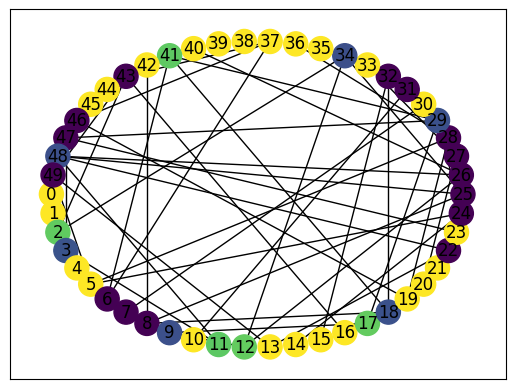

In [52]:
## generate graph weights
NN_graph_params = datalessNN_graph_params(G)

graph_order = len(G.nodes)

NN = datalessNN(
    NN_graph_params["theta_tensor"],
    NN_graph_params["layer_2_weights"],
    NN_graph_params["layer_2_biases"],
    NN_graph_params["layer_3_weights"])

################# optimization
# good and fast results on most is found at initial_learning_rate = 0.001
initial_learning_rate = 0.01
optimizer = torch.optim.Adam(NN.parameters(), lr=initial_learning_rate)
loss_fn = torch.nn.MSELoss()

theta_constraint = ZeroOneClamp()

##################################################################################################
##################################################################################################
##################################################################################################

batch_size_gen = 1
batch_size_2 = batch_size_gen

################################################################
##### X_train is the same for both gen and combined models #####
################################################################

X_train = np.ones(len(NN_graph_params["theta_tensor"]))

############################################################
### Y_train_combined is the v_d (desired value)
################################################################

P_desired = np.zeros(1)
P_desired[0] = -graph_order**2 / 2

Y_train_combined = np.zeros(shape=(batch_size_2, 1, 1))

Y_val_combined = P_desired.reshape(1, 1)
for i in range(batch_size_2):
    Y_train_combined[i, :, :] = Y_val_combined

Y_train_combined = Y_train_combined.reshape(batch_size_2, 1)

Y_desired = torch.Tensor(Y_val_combined)
Y_val_combined = Y_val_combined.reshape(1, 1, 1)
Y_val_combined = Y_val_combined.reshape(1, 1)
# Y_val_combined = Y_val_combined.reshape(3)

################################################################
### train
################################################################

training_steps = 2000
X_star = None

start = time.time()
for i in range(training_steps):
    predicted_y = NN(X_train)

    loss = loss_fn(predicted_y, Y_desired)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## normalize theta values between 0 and 1
    NN[0].apply(theta_constraint)

    X_star = NN[0].weight

    if any(X_star > 1.0) or any(X_star < 0.0):
        print(
            "exit AT training step = ",
            i,
            "; THERE IS A A VALUE IN THE WEIGHTS OUTSIDE [0,1]",
            X_star
        )
        break

    # check MAXIMAL-IS multiple thresholds !!!
    # MAXIMAL_IS_tester = [
    #     MAXIMAL_IS_checker(X_star, G, 0.3),
    #     MAXIMAL_IS_checker(X_star, G, 0.4),
    #     MAXIMAL_IS_checker(X_star, G, 0.5),
    #     MAXIMAL_IS_checker(X_star, G, 0.6),
    #     MAXIMAL_IS_checker(X_star, G, 0.7),
    # ]

    # if MAXIMAL_IS_checker(X_star, G, 0.5) == 1:
    #     X_star_thresholded_IS = np.zeros(shape=(n_inputss))
    #     for ii in range(n_inputss):
    #         if X_star[ii] > 0.5:
    #             X_star_thresholded_IS[ii] = 1
    #     length_IS = np.count_nonzero(X_star_thresholded_IS)
    #     # length_IS_w_Imp = np.count_nonzero(
    #     #     X_star_thresholded_IS
    #     # ) + solution_improve_alg(
    #     #     X_star_thresholded_IS, G, np.count_nonzero(X_star_thresholded_IS)
    #     # )
    #     print(
    #         "IS is found at step ",
    #         [i],
    #         "with size = ",
    #         length_IS,
    #         # "total with improvement = ",
    #         # length_IS_w_Imp,
    #     )

    # ## exit if we already have a Maximal-IS
    # if any(np.array(MAXIMAL_IS_tester) == 1):
    #     winning_threshold_temp = np.argmax(np.array(MAXIMAL_IS_tester))
    #     winning_threshold = [0.3, 0.4, 0.5, 0.6, 0.7][winning_threshold_temp]
    #     end = time.time()
    #     X_star_thresholded = np.zeros(shape=(n_inputss))
    #     # X_MIN_VALUE_TEST   = np.zeros(shape=(n_inputss))
    #     for ii in range(n_inputss):
    #         if X_star[ii] > winning_threshold:
    #             X_star_thresholded[ii] = 1
    #     length = np.count_nonzero(X_star_thresholded) #+ solution_improve_alg(
    #     #     X_star_thresholded, G, np.count_nonzero(X_star_thresholded)
    #     # )

    #     print(
    #         "MAXIMAL-IS IS FOUND AT training step = ",
    #         i,
    #         "; Cardinality Ours = ",
    #         [length],
    #     )
    #     # if length >= some_value_if_known:
    #     Solution_pool_length.append(length)
    #     break

    print(
        "training_step = ",
        i,
        "value = ",
        predicted_y,
        " ; desired value set for optimization = ",
        P_desired,
    )


nx.draw_networkx(G, node_color=X_star.detach().numpy(), pos=nx.shell_layout(G))